Fitting propensity score model...


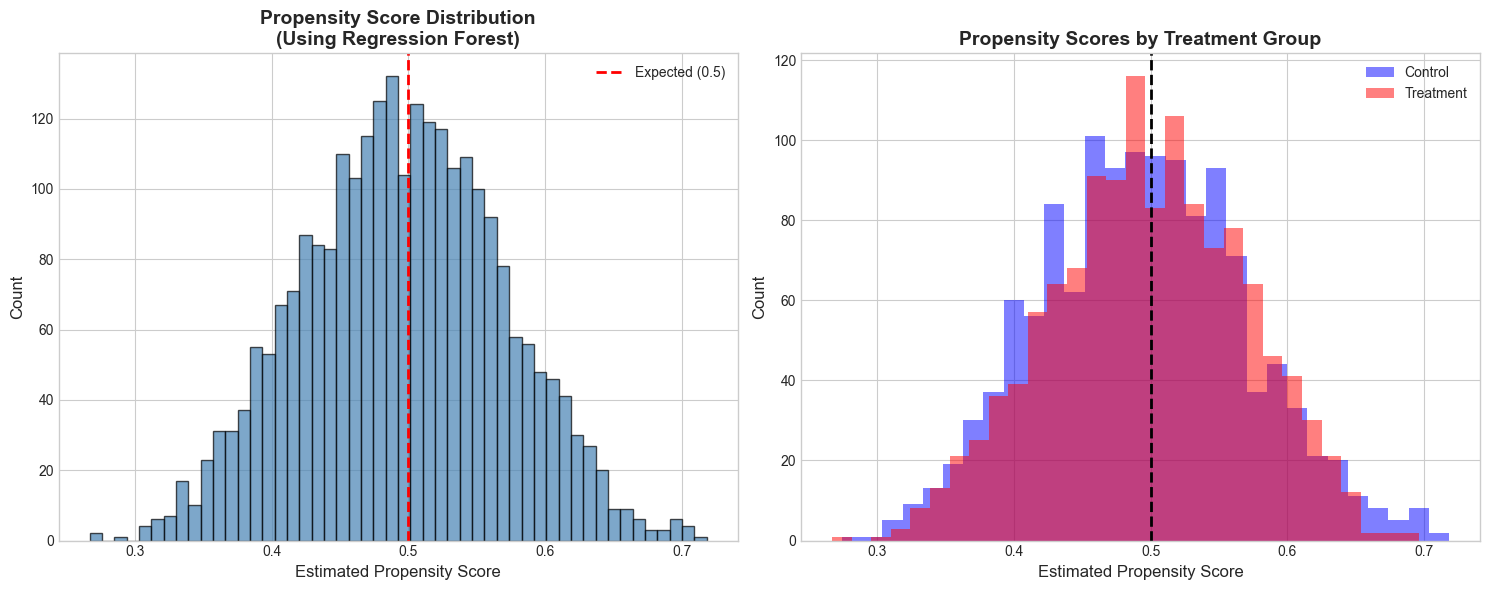


Propensity Score Summary:
Mean: 0.495 (should be ~0.5)
Std: 0.073
Min: 0.267
Max: 0.718

Treatment rate: 0.497
Mean propensity score for treated: 0.497
Mean propensity score for control: 0.493


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# Import causal forest from econml
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# Load the processed data
df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')

# ============================================================================
# 1. DATA PREPARATION (keeping your existing code)
# ============================================================================
# Create change variables
df['etf_change'] = df['lot_etf'] - df['etf']
df['stock_change'] = df['lot_stock'] - df['stock']
df['saving_change'] = df['lot_saving'] - df['saving']
df['gold_change'] = df['lot_gold'] - df['gold']
df['crypto_change'] = df['lot_crypto'] - df['crypto']

# Set seed for reproducibility
np.random.seed(42)

# Prepare covariate matrix
continuous_features = [
    'age', 'sub_financial_know', 'risk_tolerance', 'political_placement',
    'trust_government'
]
X_continuous = df[continuous_features].values

# Create binary variables
X_binary_dict = {
    'is_woman': (df['gender'] == 'Women').astype(float),
    'low_education': (df['education'] == 'Some college or lower').astype(float),
    'low_social_origin': (df['social_origin'] == 'Medium/Low').astype(float),
    'is_white': (df['race'] == 'White').astype(float),
    'is_black': (df['race'] == 'Black').astype(float),
    'is_married': (df['relationship_status'] == 'Married/Cohabited/In a union').astype(float),
    'parents_foreign': (df['parents_us_born'] == 'No').astype(float),
    'active_labor': (df['labor_force'] == 'Active').astype(float),
    'high_income': (df['income'] == 'Above median').astype(float),
    'owns_house': (df['house'] == 'Owner').astype(float),
    'financial_literate': (df['financial_literacy'] == 'Correct').astype(float)
}
X_binary = pd.DataFrame(X_binary_dict).values

# Combine continuous and binary variables
X = np.column_stack([X_continuous, X_binary])

# Create variable names for interpretation
var_names = [
    "Age", "Subj. Fin. Knowledge", "Risk Tolerance", "Political Placement", 
    "Trust in Gov.", "Woman", "Low Education", 
    "Low Social Origin", "White", "Black", "Married", "Foreign Parents", 
    "Active Labor Force", "High Income", "Owns House", "Financially Literate"
]

# Treatment and outcome
W = df['treatment'].values
Y_etf = df['etf_change'].values

# ============================================================================
# 2. CORRECTED PROPENSITY SCORE ESTIMATION
# ============================================================================
print("Fitting propensity score model...")

# METHOD 1: Use RandomForestRegressor (like R's regression_forest)
# This treats the binary treatment as continuous, matching R's approach
prop_forest_reg = RandomForestRegressor(
    n_estimators=2000, 
    max_features='sqrt',  # Use sqrt of features like R's default
    min_samples_leaf=5,   # Prevent overfitting
    random_state=42
)

# Use cross-validation to get out-of-sample predictions (prevents overfitting)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
W_hat = cross_val_predict(prop_forest_reg, X, W, cv=cv)

# Alternative: Fit on full data but with regularization
# prop_forest_reg.fit(X, W)
# W_hat = prop_forest_reg.predict(X)

# For randomized experiments, you could also just use 0.5 for everyone
# W_hat = np.ones(len(W)) * 0.5

# ============================================================================
# 3. CHECK PROPENSITY SCORE DISTRIBUTION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Histogram
ax1 = axes[0]
ax1.hist(W_hat, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Expected (0.5)')
ax1.set_xlabel('Estimated Propensity Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Propensity Score Distribution\n(Using Regression Forest)', 
             fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: Comparison by treatment group
ax2 = axes[1]
ax2.hist(W_hat[W == 0], bins=30, alpha=0.5, label='Control', color='blue')
ax2.hist(W_hat[W == 1], bins=30, alpha=0.5, label='Treatment', color='red')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Estimated Propensity Score', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Propensity Scores by Treatment Group', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPropensity Score Summary:")
print(f"Mean: {np.mean(W_hat):.3f} (should be ~0.5)")
print(f"Std: {np.std(W_hat):.3f}")
print(f"Min: {np.min(W_hat):.3f}")
print(f"Max: {np.max(W_hat):.3f}")

# Check balance
print(f"\nTreatment rate: {np.mean(W):.3f}")
print(f"Mean propensity score for treated: {np.mean(W_hat[W == 1]):.3f}")
print(f"Mean propensity score for control: {np.mean(W_hat[W == 0]):.3f}")


In [7]:
"""
Causal Forest Hyperparameter Tuning and Cross-Validation
For Randomized Financial Information Experiment (n=2500)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter
import warnings
warnings.filterwarnings('ignore')
try:
    from tqdm import tqdm
except ImportError:
    # Simple fallback if tqdm is not installed
    def tqdm(iterable, desc=None):
        return iterable
import time

# Set style for professional plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ============================================================================
# 1. HYPERPARAMETER TUNING SETUP
# ============================================================================

def evaluate_causal_forest(cf_model, X_train, Y_train, W_train, X_test, Y_test, W_test):
    """
    Evaluate causal forest performance using multiple metrics
    """
    metrics = {}
    
    # Fit the model
    cf_model.fit(Y_train, W_train, X=X_train)
    
    # 1. Get treatment effects
    te_train = cf_model.effect(X_train)
    te_test = cf_model.effect(X_test)
    
    # 2. Confidence intervals for test set
    te_test_interval = cf_model.effect_interval(X_test, alpha=0.05)
    ci_width = np.mean(te_test_interval[1] - te_test_interval[0])
    
    # 3. Heterogeneity metrics
    te_variance = np.var(te_test)
    te_iqr = np.percentile(te_test, 75) - np.percentile(te_test, 25)
    
    # 4. Coverage and precision (for randomized experiment)
    # Since true effect is unknown, we use proxy measures
    metrics['te_mean'] = np.mean(te_test)
    metrics['te_std'] = np.std(te_test)
    metrics['te_variance'] = te_variance
    metrics['te_iqr'] = te_iqr
    metrics['ci_width'] = ci_width
    metrics['n_heterogeneous'] = np.sum(np.abs(te_test - np.mean(te_test)) > np.std(te_test))
    
    # 5. Add a simple predictive performance check
    # For treated units, check if higher predicted effects correlate with better outcomes
    treated_idx = W_test == 1
    if np.sum(treated_idx) > 0:
        te_treated = te_test[treated_idx]
        y_treated = Y_test[treated_idx]
        if len(te_treated) > 1:
            correlation = np.corrcoef(te_treated, y_treated)[0, 1]
            metrics['te_outcome_corr'] = correlation
    
    return metrics, te_test

def cross_validate_causal_forest(X, Y, W, params, n_splits=5, random_state=42):
    """
    Perform cross-validation for causal forest with given parameters
    """
    # Use stratified K-fold to maintain treatment balance
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    all_metrics = []
    all_effects = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, W)):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        W_train, W_test = W[train_idx], W[test_idx]
        
        # Create model with current parameters
        cf = CausalForestDML(
            model_y=RandomForestRegressor(
                n_estimators=100,
                min_samples_leaf=max(10, params['min_samples_leaf']//2),
                max_features='sqrt',
                random_state=random_state
            ),
            model_t=RandomForestRegressor(
                n_estimators=100,
                min_samples_leaf=max(10, params['min_samples_leaf']//2),
                max_features='sqrt',
                random_state=random_state
            ),
            n_estimators=params['n_estimators'],
            min_samples_leaf=params['min_samples_leaf'],
            max_depth=params.get('max_depth', None),
            max_samples=params.get('max_samples', 0.5),
            max_features=params.get('max_features', 'sqrt'),
            random_state=random_state,
            discrete_treatment=True,
            cv=3,
            inference='blb'
        )
        
        # Evaluate
        metrics, effects = evaluate_causal_forest(
            cf, X_train, Y_train, W_train, X_test, Y_test, W_test
        )
        metrics['fold'] = fold
        
        all_metrics.append(metrics)
        all_effects.append(effects)
    
    return pd.DataFrame(all_metrics), all_effects

# ============================================================================
# 2. GRID SEARCH FOR HYPERPARAMETERS
# ============================================================================

print("=" * 70)
print("CAUSAL FOREST HYPERPARAMETER TUNING")
print("=" * 70)

# Define parameter grid
param_grid = {
    'min_samples_leaf': [5, 10, 20, 30, 50],
    'n_estimators': [2000, 3000, 4000],
    'max_samples': [0.45, 0.5, 0.55],
    'max_features': ['sqrt', 'log2', 0.5]
}

# For demonstration, we'll use a subset of the grid
# In practice, you might want to test all combinations
# Note: max_samples must be <= 0.5 for honest causal inference
tuning_configs = [
    {'min_samples_leaf': 5, 'n_estimators': 2000, 'max_samples': 0.5, 'max_features': 'sqrt'},
    {'min_samples_leaf': 10, 'n_estimators': 3000, 'max_samples': 0.5, 'max_features': 'sqrt'},
    {'min_samples_leaf': 20, 'n_estimators': 4000, 'max_samples': 0.5, 'max_features': 'sqrt'},
    {'min_samples_leaf': 30, 'n_estimators': 4000, 'max_samples': 0.5, 'max_features': 'sqrt'},
    {'min_samples_leaf': 50, 'n_estimators': 4000, 'max_samples': 0.5, 'max_features': 'sqrt'},
    {'min_samples_leaf': 20, 'n_estimators': 4000, 'max_samples': 0.45, 'max_features': 'sqrt'},
    {'min_samples_leaf': 20, 'n_estimators': 4000, 'max_samples': 0.48, 'max_features': 'sqrt'},  # Changed from 0.55
    {'min_samples_leaf': 20, 'n_estimators': 4000, 'max_samples': 0.5, 'max_features': 'log2'},
    {'min_samples_leaf': 20, 'n_estimators': 4000, 'max_samples': 0.5, 'max_features': 0.5},
]

# Store results
tuning_results = []

print(f"\nTesting {len(tuning_configs)} parameter configurations...")
print("-" * 70)

for i, params in enumerate(tqdm(tuning_configs, desc="Tuning Progress")):
    print(f"\nConfiguration {i+1}/{len(tuning_configs)}:")
    print(f"  min_samples_leaf: {params['min_samples_leaf']}")
    print(f"  n_estimators: {params['n_estimators']}")
    print(f"  max_samples: {params['max_samples']}")
    print(f"  max_features: {params['max_features']}")
    
    # Run cross-validation
    start_time = time.time()
    cv_metrics, cv_effects = cross_validate_causal_forest(
        X, Y_etf, W, params, n_splits=5
    )
    elapsed_time = time.time() - start_time
    
    # Aggregate results
    result = {
        'config_id': i,
        'min_samples_leaf': params['min_samples_leaf'],
        'n_estimators': params['n_estimators'],
        'max_samples': params['max_samples'],
        'max_features': str(params['max_features']),
        'te_mean': cv_metrics['te_mean'].mean(),
        'te_std': cv_metrics['te_std'].mean(),
        'te_variance': cv_metrics['te_variance'].mean(),
        'te_iqr': cv_metrics['te_iqr'].mean(),
        'ci_width': cv_metrics['ci_width'].mean(),
        'n_heterogeneous': cv_metrics['n_heterogeneous'].mean(),
        'time_seconds': elapsed_time
    }
    
    # Add optional metrics if they exist
    if 'te_outcome_corr' in cv_metrics.columns:
        result['te_outcome_corr'] = cv_metrics['te_outcome_corr'].mean()
    
    tuning_results.append(result)
    
    print(f"  Mean TE: {result['te_mean']:.4f} ± {result['te_std']:.4f}")
    print(f"  Heterogeneity (IQR): {result['te_iqr']:.4f}")
    print(f"  CI Width: {result['ci_width']:.4f}")
    print(f"  Time: {elapsed_time:.1f}s")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(tuning_results)

# ============================================================================
# 3. ANALYZE TUNING RESULTS
# ============================================================================

print("\n" + "=" * 70)
print("TUNING RESULTS SUMMARY")
print("=" * 70)

# Create scoring function (lower is better)
# Balance between detecting heterogeneity and having precise estimates
# You can adjust these weights based on your priorities:
# - Increase heterogeneity_weight if finding different responders is crucial
# - Increase precision_weight if you need more confident estimates
heterogeneity_weight = 0.4  # Weight for heterogeneity (negative because we want high variance)
precision_weight = 0.6      # Weight for precision (we want narrow CIs)

# Normalize metrics before scoring to make them comparable
results_df['te_variance_norm'] = (results_df['te_variance'] - results_df['te_variance'].min()) / (results_df['te_variance'].max() - results_df['te_variance'].min())
results_df['ci_width_norm'] = (results_df['ci_width'] - results_df['ci_width'].min()) / (results_df['ci_width'].max() - results_df['ci_width'].min())

results_df['score'] = (
    - results_df['te_variance_norm'] * heterogeneity_weight  # Want high variance (negative)
    + results_df['ci_width_norm'] * precision_weight         # Want low CI width
)

# Rank configurations
results_df['rank'] = results_df['score'].rank()
results_df_sorted = results_df.sort_values('rank')

print("\nTop 5 Configurations (balanced score):")
print(results_df_sorted[['rank', 'min_samples_leaf', 'n_estimators', 'max_samples', 
                         'max_features', 'te_variance', 'ci_width', 'score']].head())

# Best configuration
best_config = results_df_sorted.iloc[0]
print(f"\n🏆 BEST CONFIGURATION:")
print(f"  min_samples_leaf: {best_config['min_samples_leaf']:.0f}")
print(f"  n_estimators: {best_config['n_estimators']:.0f}")
print(f"  max_samples: {best_config['max_samples']:.2f}")
print(f"  max_features: {best_config['max_features']}")
print(f"  Treatment Effect Variance: {best_config['te_variance']:.4f}")
print(f"  CI Width: {best_config['ci_width']:.4f}")



CAUSAL FOREST HYPERPARAMETER TUNING

Testing 9 parameter configurations...
----------------------------------------------------------------------


Tuning Progress:   0%|          | 0/9 [00:00<?, ?it/s]


Configuration 1/9:
  min_samples_leaf: 5
  n_estimators: 2000
  max_samples: 0.5
  max_features: sqrt


Tuning Progress:  11%|█         | 1/9 [00:13<01:49, 13.71s/it]

  Mean TE: 17.9081 ± 5.4736
  Heterogeneity (IQR): 8.5202
  CI Width: 12.0850
  Time: 13.7s

Configuration 2/9:
  min_samples_leaf: 10
  n_estimators: 3000
  max_samples: 0.5
  max_features: sqrt


Tuning Progress:  22%|██▏       | 2/9 [00:32<01:56, 16.64s/it]

  Mean TE: 17.8796 ± 4.8402
  Heterogeneity (IQR): 7.6683
  CI Width: 9.8646
  Time: 18.7s

Configuration 3/9:
  min_samples_leaf: 20
  n_estimators: 4000
  max_samples: 0.5
  max_features: sqrt


Tuning Progress:  33%|███▎      | 3/9 [00:55<01:57, 19.63s/it]

  Mean TE: 17.9010 ± 4.2620
  Heterogeneity (IQR): 6.7339
  CI Width: 8.4894
  Time: 23.2s

Configuration 4/9:
  min_samples_leaf: 30
  n_estimators: 4000
  max_samples: 0.5
  max_features: sqrt


Tuning Progress:  44%|████▍     | 4/9 [01:19<01:46, 21.27s/it]

  Mean TE: 17.9082 ± 3.8646
  Heterogeneity (IQR): 6.0327
  CI Width: 7.9335
  Time: 23.8s

Configuration 5/9:
  min_samples_leaf: 50
  n_estimators: 4000
  max_samples: 0.5
  max_features: sqrt


Tuning Progress:  56%|█████▌    | 5/9 [01:42<01:27, 21.85s/it]

  Mean TE: 17.9492 ± 3.3794
  Heterogeneity (IQR): 5.3156
  CI Width: 7.2088
  Time: 22.9s

Configuration 6/9:
  min_samples_leaf: 20
  n_estimators: 4000
  max_samples: 0.45
  max_features: sqrt


Tuning Progress:  67%|██████▋   | 6/9 [02:05<01:06, 22.30s/it]

  Mean TE: 17.9051 ± 4.1008
  Heterogeneity (IQR): 6.4775
  CI Width: 8.0390
  Time: 23.2s

Configuration 7/9:
  min_samples_leaf: 20
  n_estimators: 4000
  max_samples: 0.48
  max_features: sqrt


Tuning Progress:  78%|███████▊  | 7/9 [02:28<00:45, 22.65s/it]

  Mean TE: 17.8992 ± 4.1852
  Heterogeneity (IQR): 6.5991
  CI Width: 8.3785
  Time: 23.3s

Configuration 8/9:
  min_samples_leaf: 20
  n_estimators: 4000
  max_samples: 0.5
  max_features: log2


Tuning Progress:  89%|████████▉ | 8/9 [02:52<00:22, 22.99s/it]

  Mean TE: 17.9010 ± 4.2620
  Heterogeneity (IQR): 6.7339
  CI Width: 8.4894
  Time: 23.7s

Configuration 9/9:
  min_samples_leaf: 20
  n_estimators: 4000
  max_samples: 0.5
  max_features: 0.5


Tuning Progress: 100%|██████████| 9/9 [03:16<00:00, 21.83s/it]

  Mean TE: 17.8910 ± 4.4433
  Heterogeneity (IQR): 7.0357
  CI Width: 9.6374
  Time: 23.9s

TUNING RESULTS SUMMARY

Top 5 Configurations (balanced score):
   rank  min_samples_leaf  n_estimators  max_samples max_features  \
5   1.0                20          4000         0.45         sqrt   
4   2.0                50          4000         0.50         sqrt   
2   3.5                20          4000         0.50         sqrt   
7   3.5                20          4000         0.50         log2   
6   5.0                20          4000         0.48         sqrt   

   te_variance  ci_width     score  
5    17.013574  8.039044 -0.014517  
4    11.580273  7.208825  0.000000  
2    18.398043  8.489388  0.011167  
7    18.398043  8.489388  0.011167  
6    17.737181  8.378481  0.011711  

🏆 BEST CONFIGURATION:
  min_samples_leaf: 20
  n_estimators: 4000
  max_samples: 0.45
  max_features: sqrt
  Treatment Effect Variance: 17.0136
  CI Width: 8.0390


In [8]:


# ============================================================================
# FINAL MODEL WITH BEST PARAMETERS
# ============================================================================

print("\n" + "=" * 70)
print("FITTING FINAL MODEL WITH OPTIMAL PARAMETERS")
print("=" * 70)

# Extract best parameters
best_params = {
    'min_samples_leaf': int(best_config['min_samples_leaf']),
    'n_estimators': int(best_config['n_estimators']),
    'max_samples': best_config['max_samples'],
    'max_features': best_config['max_features'] if best_config['max_features'] in ['sqrt', 'log2'] 
                    else float(best_config['max_features'])
}

# Fit final model with best parameters
final_cf = CausalForestDML(
    model_y=RandomForestRegressor(
        n_estimators=100,
        min_samples_leaf=max(10, best_params['min_samples_leaf']//2),
        max_features='sqrt',
        random_state=42
    ),
    model_t=RandomForestRegressor(
        n_estimators=100,
        min_samples_leaf=max(10, best_params['min_samples_leaf']//2),
        max_features='sqrt',
        random_state=42
    ),
    n_estimators=best_params['n_estimators'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_depth=None,
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    random_state=42,
    discrete_treatment=True,
    cv=3,
    inference='blb'
)

# Fit on full dataset
print("Fitting final causal forest...")
final_cf.fit(Y_etf, W, X=X, cache_values=True)

# Get treatment effects
te_final = final_cf.effect(X)
te_final_interval = final_cf.effect_interval(X, alpha=0.05)

print(f"\nFinal Model Statistics:")
print(f"  Average Treatment Effect: {np.mean(te_final):.4f}")
print(f"  Treatment Effect Std Dev: {np.std(te_final):.4f}")
print(f"  Treatment Effect Range: [{np.min(te_final):.4f}, {np.max(te_final):.4f}]")
print(f"  Median CI Width: {np.median(te_final_interval[1] - te_final_interval[0]):.4f}")


FITTING FINAL MODEL WITH OPTIMAL PARAMETERS
Fitting final causal forest...

Final Model Statistics:
  Average Treatment Effect: 17.9154
  Treatment Effect Std Dev: 4.4199
  Treatment Effect Range: [7.7291, 26.6599]
  Median CI Width: 7.8742



HETEROGENEITY ANALYSIS

Treatment Effect Distribution by Quartiles:
  Low: Mean TE = 11.9003, N = 643
  Medium-Low: Mean TE = 16.5389, N = 642
  Medium-High: Mean TE = 19.9036, N = 642
  High: Mean TE = 23.3196, N = 643


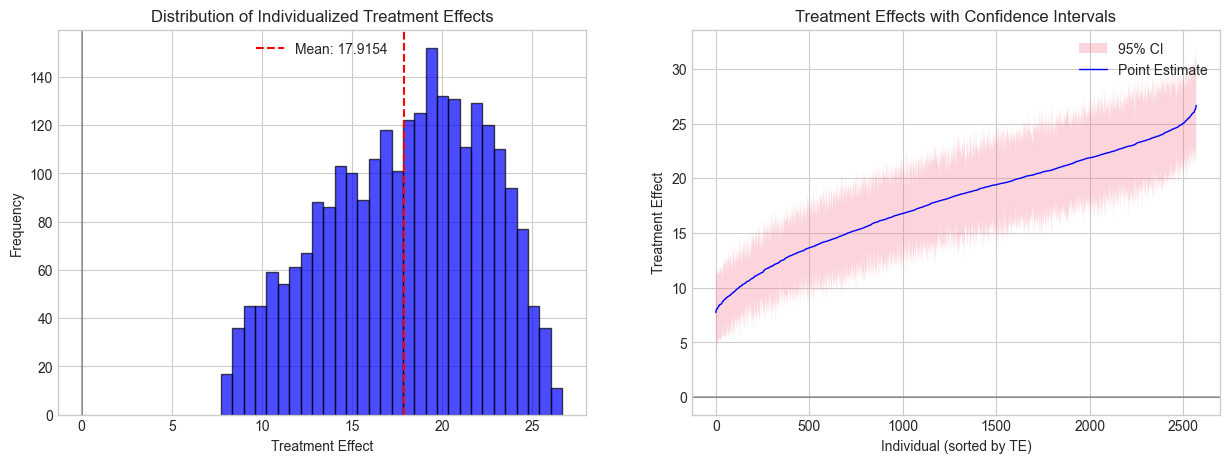

In [9]:

# ============================================================================
# HETEROGENEITY ANALYSIS WITH OPTIMAL MODEL
# ============================================================================

print("\n" + "=" * 70)
print("HETEROGENEITY ANALYSIS")
print("=" * 70)

# Create heterogeneity groups
te_quartiles = np.percentile(te_final, [25, 50, 75])
heterogeneity_groups = pd.cut(te_final, 
                              bins=[-np.inf] + list(te_quartiles) + [np.inf],
                              labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

print("\nTreatment Effect Distribution by Quartiles:")
for group in ['Low', 'Medium-Low', 'Medium-High', 'High']:
    mask = heterogeneity_groups == group
    print(f"  {group}: Mean TE = {np.mean(te_final[mask]):.4f}, N = {np.sum(mask)}")

# Visualize final results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of treatment effects
ax = axes[0]
ax.hist(te_final, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(np.mean(te_final), color='red', linestyle='--', label=f'Mean: {np.mean(te_final):.4f}')
ax.axvline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Treatment Effect')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Individualized Treatment Effects')
ax.legend()

# Confidence intervals
ax = axes[1]
sorted_idx = np.argsort(te_final)
ax.fill_between(range(len(te_final)), 
                te_final_interval[0][sorted_idx], 
                te_final_interval[1][sorted_idx],
                alpha=0.3, label='95% CI')
ax.plot(te_final[sorted_idx], 'b-', linewidth=1, label='Point Estimate')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Individual (sorted by TE)')
ax.set_ylabel('Treatment Effect')
ax.set_title('Treatment Effects with Confidence Intervals')
ax.legend()





VARIABLE IMPORTANCE ANALYSIS


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Top 10 Variables Driving Treatment Effect Heterogeneity:
            variable  importance  importance_pct  cumulative_pct
Subj. Fin. Knowledge    0.224924       22.492390       22.492390
      Risk Tolerance    0.139318       13.931804       36.424195
                 Age    0.131342       13.134247       49.558441
       Trust in Gov.    0.098874        9.887361       59.445802
   Low Social Origin    0.088497        8.849726       68.295528
 Political Placement    0.066925        6.692548       74.988076
       Low Education    0.048297        4.829684       79.817760
               Woman    0.044250        4.424963       84.242723
         High Income    0.035829        3.582889       87.825611
               White    0.031571        3.157143       90.982755


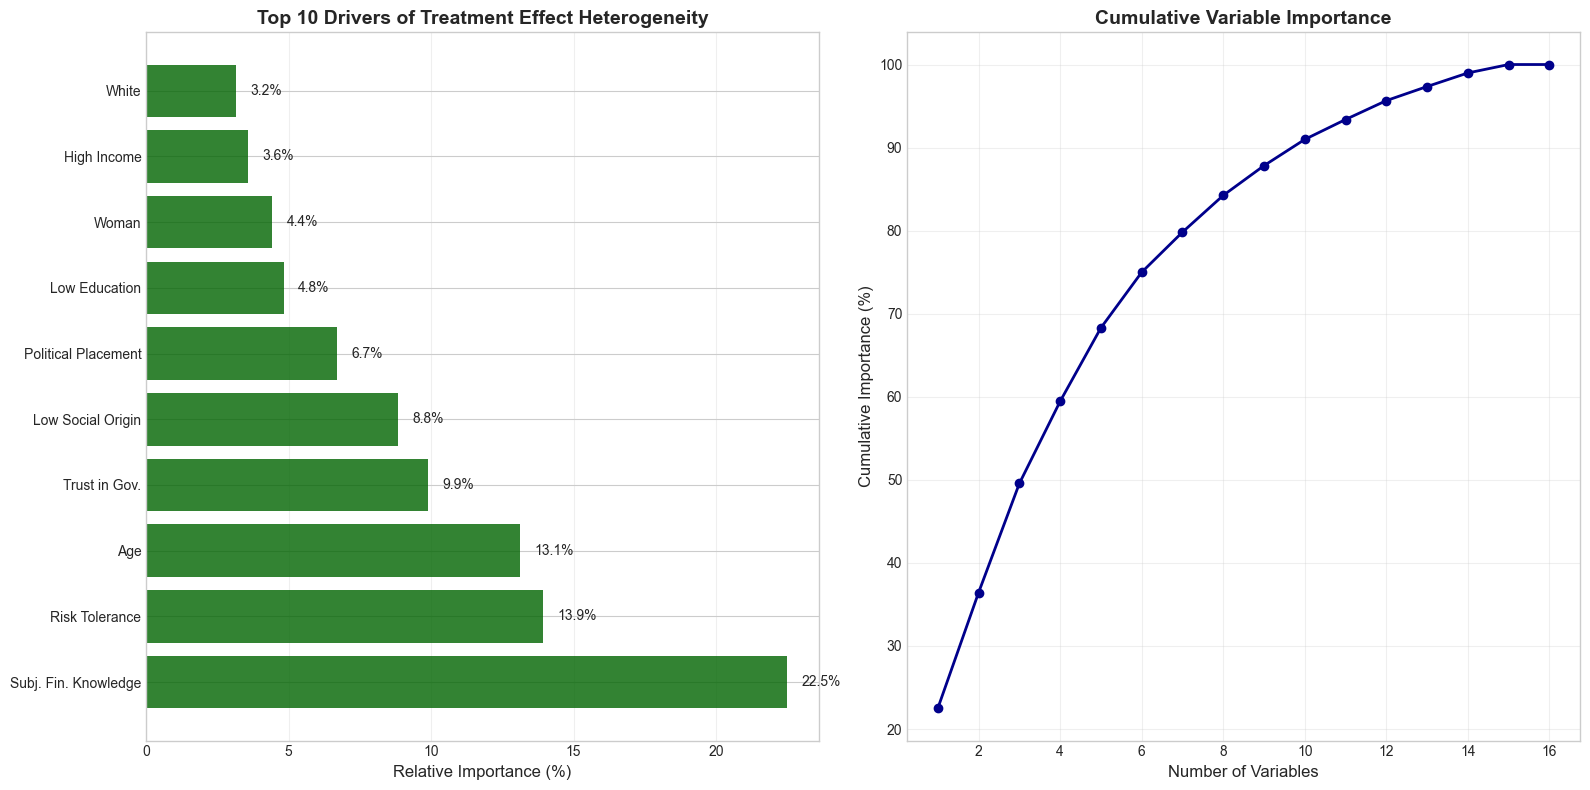

In [10]:
# ============================================================================
# 3. ENHANCED VARIABLE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "=" * 60)
print("VARIABLE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importances if available
if hasattr(final_cf, 'feature_importances_'):
    varimp = final_cf.feature_importances_
else:
    # Alternative: Use tree interpreter to get importances
    intrp = SingleTreeCateInterpreter(max_depth=5, min_samples_leaf=50)
    intrp.interpret(final_cf, X)
    varimp = intrp.feature_importances_

# Create importance dataframe
varimp_df = pd.DataFrame({
    'variable': var_names,
    'importance': varimp
}).sort_values('importance', ascending=False)

varimp_df['importance_pct'] = varimp_df['importance'] / varimp_df['importance'].sum() * 100
varimp_df['cumulative_pct'] = varimp_df['importance_pct'].cumsum()

print("\nTop 10 Variables Driving Treatment Effect Heterogeneity:")
print(varimp_df.head(10).to_string(index=False))

# Enhanced variable importance plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Bar chart of top 10
top10 = varimp_df.head(10)
ax1.barh(range(len(top10)), top10['importance_pct'].values, color='darkgreen', alpha=0.8)
ax1.set_yticks(range(len(top10)))
ax1.set_yticklabels(top10['variable'].values)
ax1.set_xlabel('Relative Importance (%)', fontsize=12)
ax1.set_title('Top 10 Drivers of Treatment Effect Heterogeneity', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, v in enumerate(top10['importance_pct'].values):
    ax1.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10)

# Plot 2: Cumulative importance
ax2.plot(range(1, len(varimp_df) + 1), varimp_df['cumulative_pct'].values, 
         'o-', color='darkblue', linewidth=2)
#ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
ax2.set_xlabel('Number of Variables', fontsize=12)
ax2.set_ylabel('Cumulative Importance (%)', fontsize=12)
ax2.set_title('Cumulative Variable Importance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


HETEROGENEITY TESTING

NON-LINEAR HETEROGENEITY PATTERNS


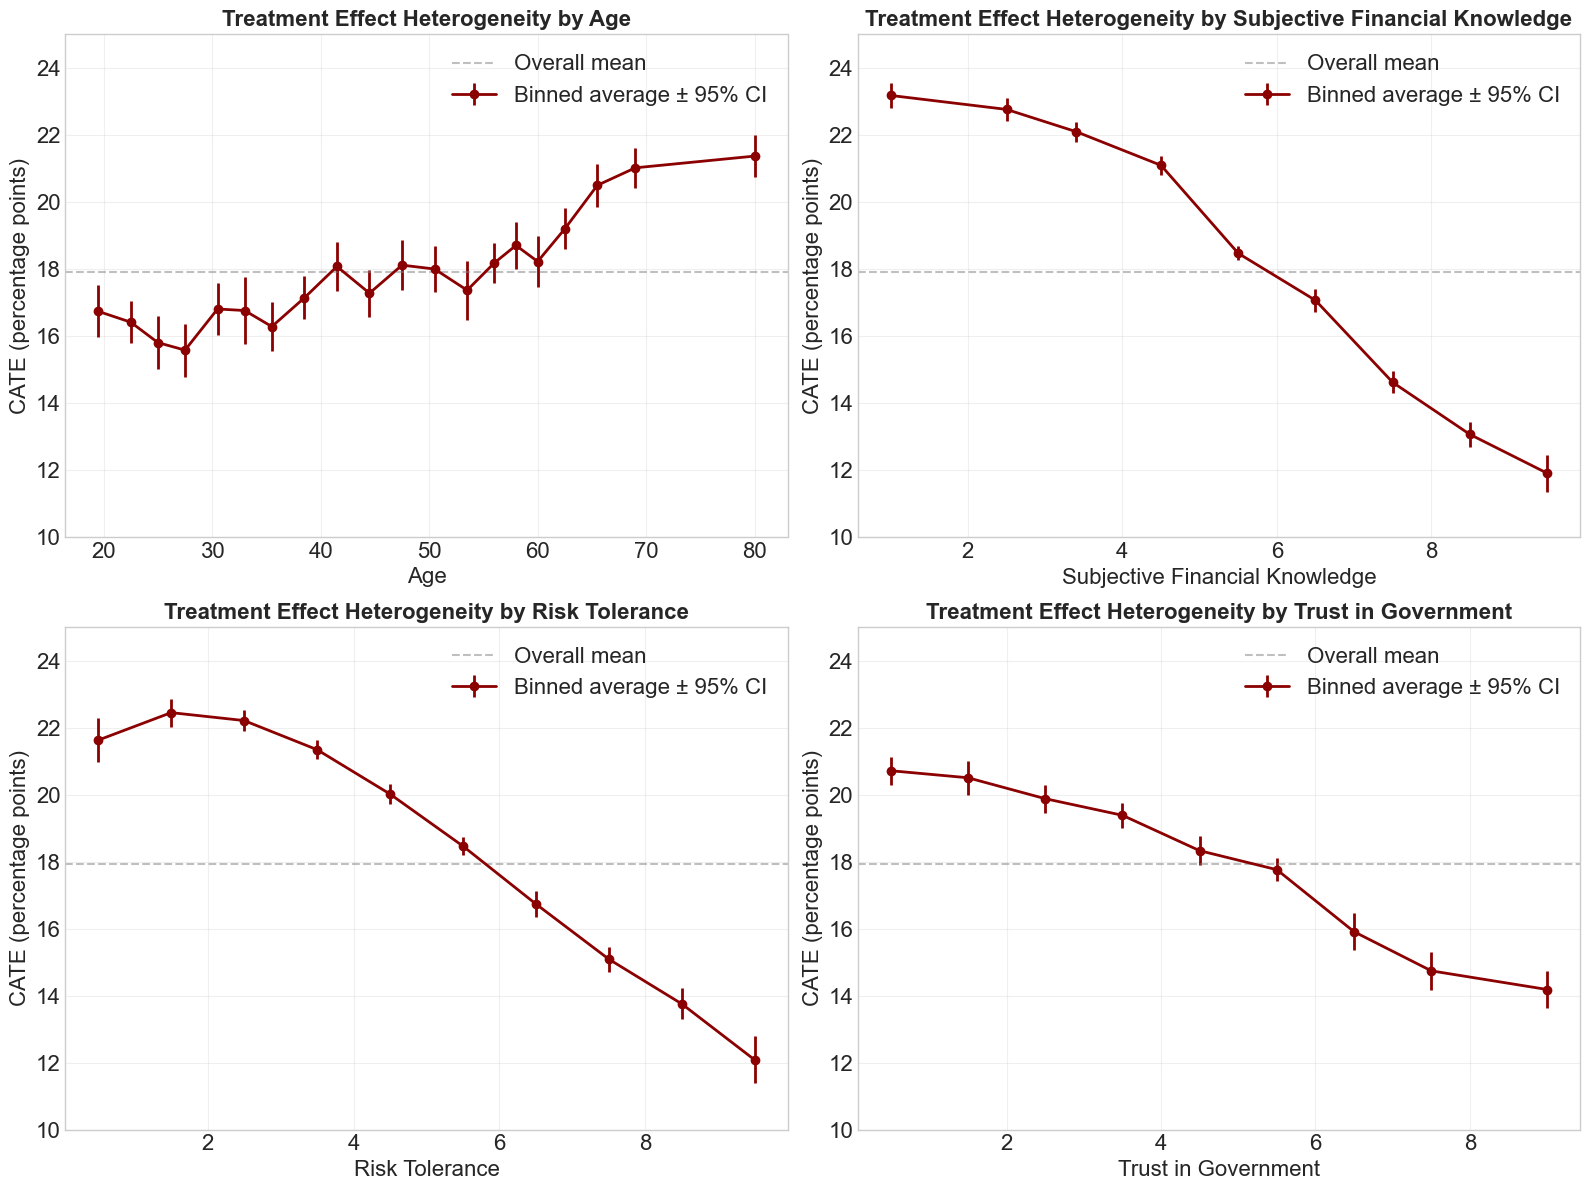

In [11]:
# ============================================================================
# COMPREHENSIVE HETEROGENEITY TESTING
# ============================================================================

print("\n" + "=" * 60)
print("HETEROGENEITY TESTING")
print("=" * 60)

# Get CATE predictions with confidence intervals
tau_hat = final_cf.effect(X)
tau_hat_interval = final_cf.effect_interval(X, alpha=0.05)
tau_lower = tau_hat_interval[0]
tau_upper = tau_hat_interval[1]
tau_se = (tau_upper - tau_lower) / (2 * 1.96)  # Approximate SE

# Add to dataframe
df['tau_hat'] = tau_hat
df['tau_se'] = tau_se
df['tau_lower'] = tau_lower
df['tau_upper'] = tau_upper

# ============================================================================
# LINEAR HETEROGENEITY PATTERNS
# ============================================================================

print("\n" + "=" * 60)
print("NON-LINEAR HETEROGENEITY PATTERNS")
print("=" * 60)

# Select key continuous variables
continuous_vars = ['age', 'sub_financial_know', 'risk_tolerance', 'trust_government']
continuous_labels = ['Age', 'Subjective Financial Knowledge', 'Risk Tolerance', 'Trust in Government']

# Create heterogeneity plots (no scatter, no smoothed trend, no Spearman stats)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (var, label) in enumerate(zip(continuous_vars, continuous_labels)):
    ax = axes[i]
    
    # Create binned averages for cleaner visualization
    var_data = df[var].values
    n_bins = 20
    bin_edges = np.percentile(var_data, np.linspace(0, 100, n_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    binned_cate = []
    binned_se = []
    
    for j in range(n_bins):
        mask = (var_data >= bin_edges[j]) & (var_data < bin_edges[j + 1])
        if mask.sum() > 0:
            binned_cate.append(np.mean(tau_hat[mask]))
            binned_se.append(np.std(tau_hat[mask]) / np.sqrt(mask.sum()))
        else:
            binned_cate.append(np.nan)
            binned_se.append(np.nan)
    
    binned_cate = np.array(binned_cate)
    binned_se = np.array(binned_se)
    
    # Plot binned averages with error bars (kept)
    valid_bins = ~np.isnan(binned_cate)
    ax.errorbar(
        bin_centers[valid_bins], binned_cate[valid_bins],
        yerr=1.96 * binned_se[valid_bins],
        fmt='o-', color='darkred', linewidth=2, markersize=6,
        label='Binned average ± 95% CI'
    )
    
    # Reference lines (kept)
    ax.axhline(y=np.mean(tau_hat), color='gray', linestyle='--', alpha=0.5, label='Overall mean')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_ylim(10, 25)
    ax.legend(loc='best', fontsize=16)      
    ax.tick_params(axis='both', labelsize=16)  
    ax.set_xlabel(label, fontsize=16)
    ax.set_ylabel('CATE (percentage points)', fontsize=16)
    ax.set_title(f'Treatment Effect Heterogeneity by {label}', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=16)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


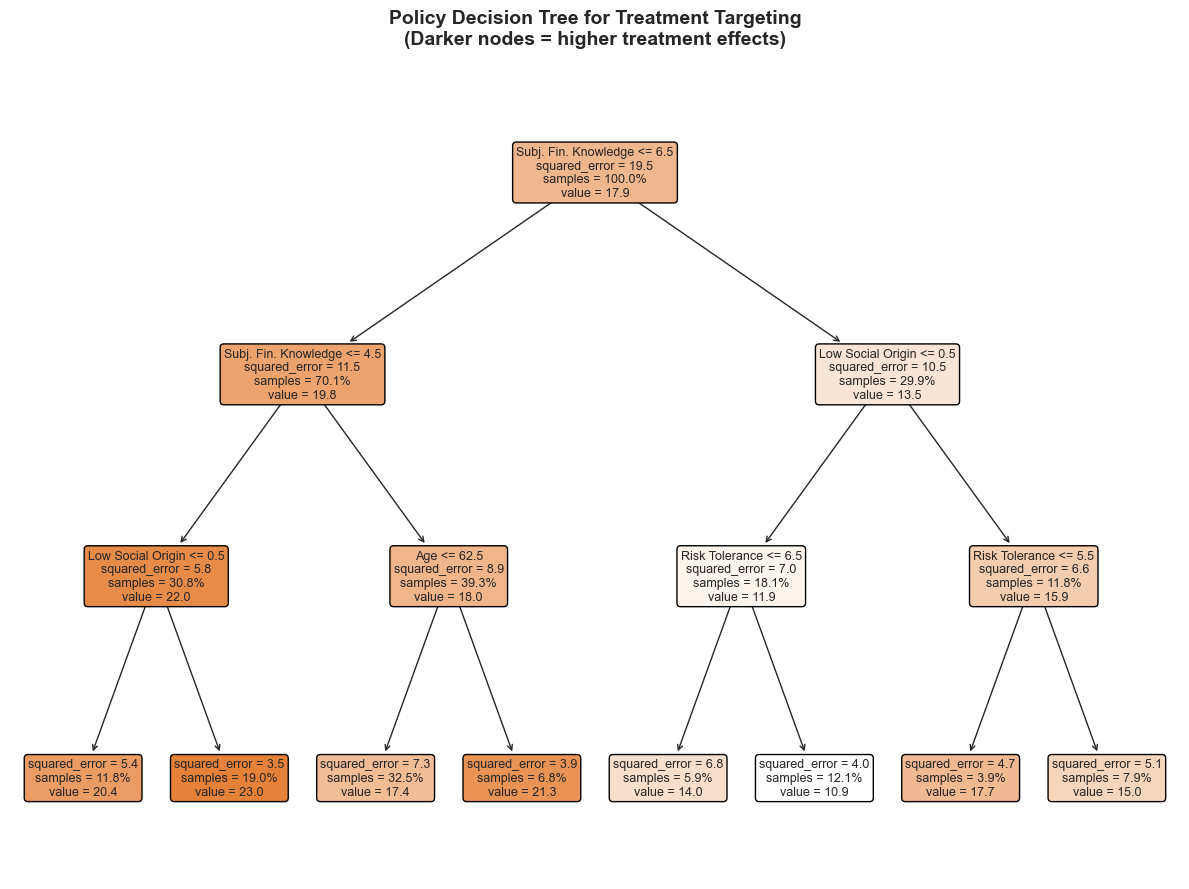

In [33]:
# ============================================================================
# CREATE ONLY PLOT 1 (Policy Decision Tree)
# ============================================================================

fig, ax1 = plt.subplots(figsize=(12, 9))

plot_tree(
    policy_tree,
    feature_names=var_names,
    filled=True,
    rounded=True,
    fontsize=9,
    ax=ax1,
    proportion=True,
    precision=1
)

ax1.set_title(
    'Policy Decision Tree for Treatment Targeting\n(Darker nodes = higher treatment effects)',
    fontsize=14, fontweight='bold', pad=20
)

plt.tight_layout()
plt.show()


POLICY TREE ANALYSIS

Tree Performance:
  R-squared: 0.724
  Number of leaves: 8
  Average treatment effect: 17.92pp


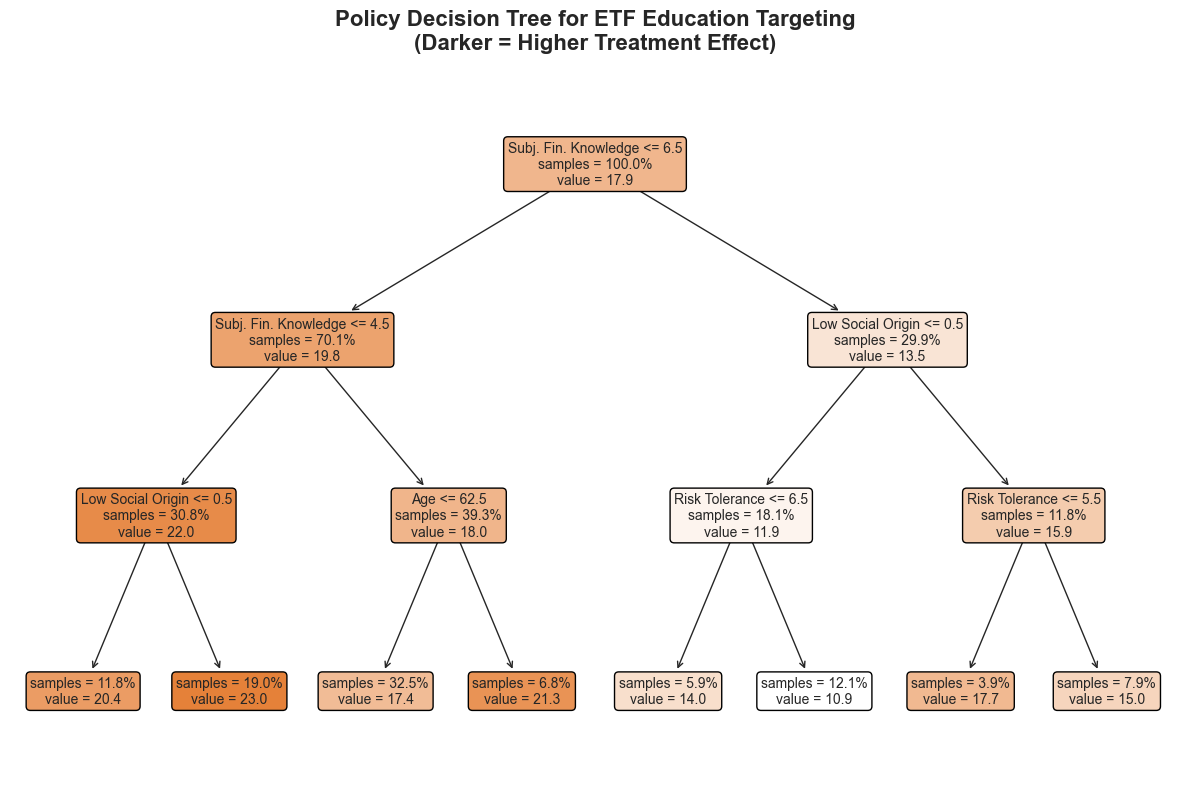

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# POLICY TREE FOR TREATMENT TARGETING
# ============================================================================

# Assuming your data is already loaded with:
# - X: feature matrix
# - te_final: treatment effects from causal forest
# - var_names: variable names
# - df: original dataframe

# Create the policy tree
policy_tree = DecisionTreeRegressor(
    max_depth=3,  # Keep shallow for interpretability
    min_samples_leaf=100,  # Ensure robust splits
    min_samples_split=200,
    random_state=42
)

# Fit the tree to predict treatment effects
policy_tree.fit(X, te_final)

print("=" * 70)
print("POLICY TREE ANALYSIS")
print("=" * 70)
print(f"\nTree Performance:")
print(f"  R-squared: {policy_tree.score(X, te_final):.3f}")
print(f"  Number of leaves: {policy_tree.get_n_leaves()}")
print(f"  Average treatment effect: {np.mean(te_final):.2f}pp")

# ============================================================================
# VISUALIZE THE TREE
# ============================================================================

plt.figure(figsize=(12, 8))
plot_tree(policy_tree, 
          feature_names=var_names,
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True,
          precision=1,
          impurity=False)  # Don't show impurity to keep it clean

plt.title('Policy Decision Tree for ETF Education Targeting\n(Darker = Higher Treatment Effect)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()
